In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
url = '/gdrive/MyDrive/Colab Notebooks/tidy_df.csv'
df = pd.read_csv(url)

In [ ]:
all_descriptions = list(df['cleaned_description'].unique())
len(all_descriptions)

3559

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')

In [ ]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [ ]:
embeddings_use = embed(model_use, 'use', all_descriptions)

In [ ]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_descriptions)

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_descriptions)

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_descriptions)

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
embeddings = [embeddings_use, embeddings_st1, embeddings_st2, embeddings_st3]

for embedding in embeddings:
    print(embedding.shape)

(3559, 512)
(3559, 768)
(3559, 384)
(3559, 768)


In [ ]:
umap_embeddings = (umap.UMAP(n_neighbors = 20, 
                                n_components = 2, 
                                metric = 'cosine', 
                                random_state=0)
                            .fit_transform(embeddings_st1))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
clusters = hdbscan.HDBSCAN(min_cluster_size = 35, 
                               min_samples = 5,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
labels_def, cost_def = score_clusters(clusters)
print(labels_def)
print(cost_def)

31
0.23826917673503792


In [ ]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [ ]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

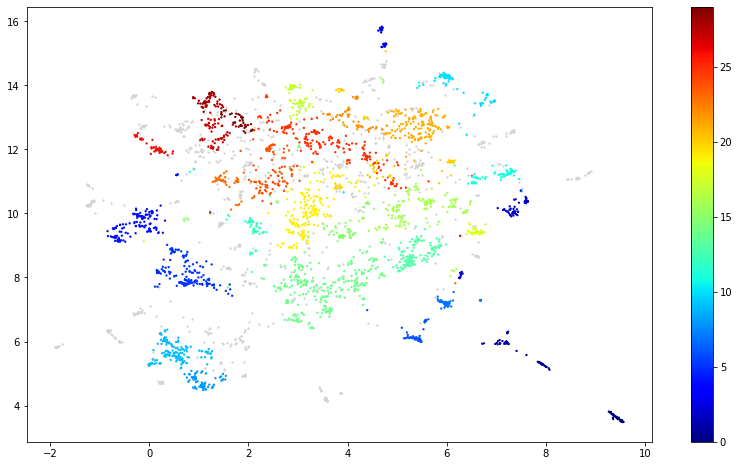

In [ ]:
plot_clusters(embeddings_st1, clusters)

So far, even in comparison to the models and graphs below that use Bayesian Optimization, this is the best clustering I have been able to achieve with UMAP + HDBSCAN. Unfortunately, 31 clusters is a far greater business segmentation than I intended and nearly a quarter of the data gets classified as noise.

In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [ ]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [ ]:

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(2,16)),
    "n_components": hp.choice('n_components', range(2,11)),
    "min_cluster_size": hp.choice('min_cluster_size', range(25,50)),
    "random_state": 42
}

label_lower = 2
label_upper = 10
max_evals = 100

In [ ]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [41:02<00:00, 24.62s/it, best loss: 0.005057600449564484]
best:
{'min_cluster_size': 33, 'n_components': 5, 'n_neighbors': 12, 'random_state': 42}
label count: 3


In [ ]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [45:10<00:00, 27.11s/it, best loss: 0.0]
best:
{'min_cluster_size': 30, 'n_components': 9, 'n_neighbors': 14, 'random_state': 42}
label count: 2


In [ ]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [37:32<00:00, 22.52s/it, best loss: 0.2508710311885361]
best:
{'min_cluster_size': 2, 'n_components': 5, 'n_neighbors': 3, 'random_state': 42}
label count: 648


In [ ]:
hspace2 = {
    "n_neighbors": hp.choice('n_neighbors', range(2,20)),
    "n_components": hp.choice('n_components', range(2,11)),
    "min_cluster_size": hp.choice('min_cluster_size', range(5,50)),
    "random_state": 42
}

label_lower = 5
label_upper = 15
max_evals = 80

In [ ]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3, 
                                                                 space=hspace2, 
                                                                 label_lower=3, 
                                                                 label_upper=15, 
                                                                 max_evals=100)

100%|██████████| 100/100 [46:59<00:00, 28.19s/it, best loss: 0.000561955605507165]
best:
{'min_cluster_size': 32, 'n_components': 4, 'n_neighbors': 18, 'random_state': 42}
label count: 3


In [ ]:
unique_descriptions = df['cleaned_description'].unique()
unique_descriptions

array(['hanging heart tlight holder', 'metal lantern',
       'cream cupid heart coat hanger', ..., 'card hanging bauble',
       'letter u bling key ring', 'cream hanging heart tlight holder'],
      dtype=object)

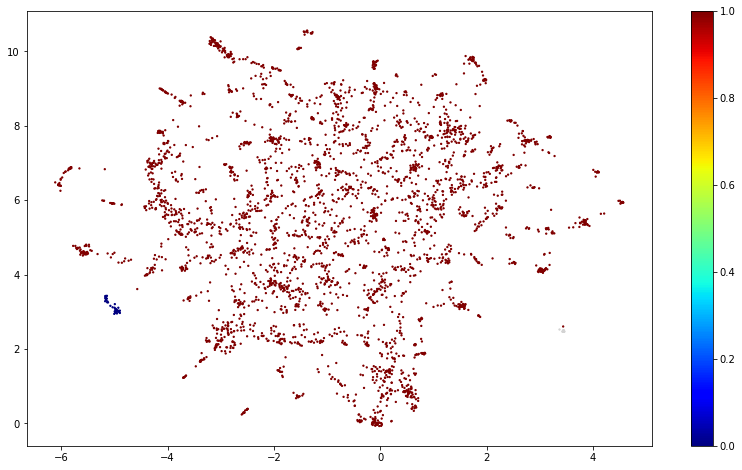

In [ ]:
plot_clusters(embeddings_use, best_clusters_use)

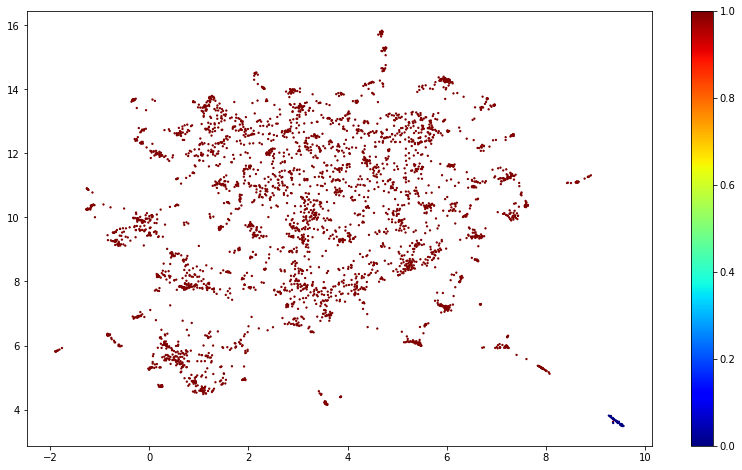

In [ ]:
plot_clusters(embeddings_st1, best_clusters_st1)

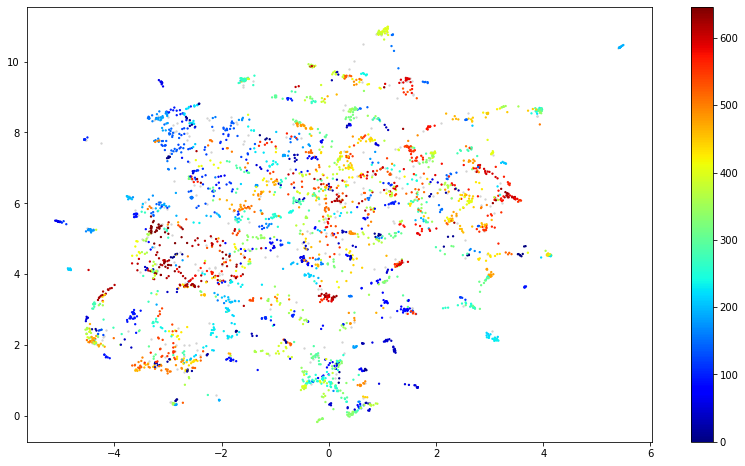

In [ ]:
plot_clusters(embeddings_st2, best_clusters_st2)

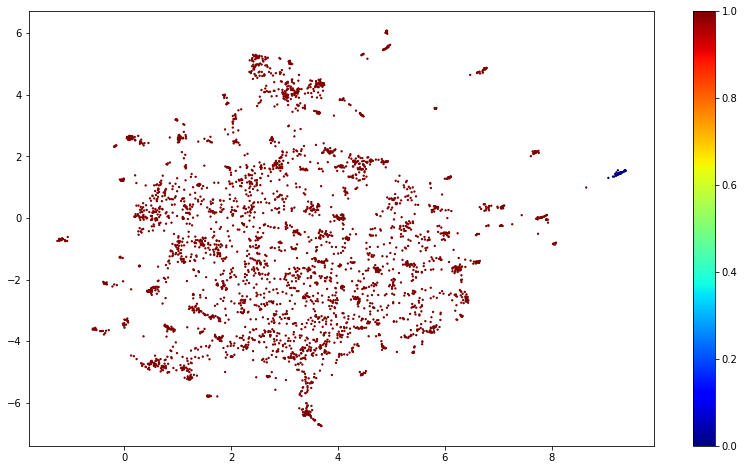

In [ ]:
plot_clusters(embeddings_st3, best_clusters_st3)

As I tweak the paramaters, UMAP + HDBSCAN have produced two outcomes. The first outcome is to produce a desirable number of clusters, 3, but to put almost everything into one cluster, with the other two clusters being tiny groups at the fringes of the graph. The second outcome is a proliferation of clusters. In the USE model at the beginning this was usually around 35, but with the other models has been over 600 as can be seen with embeddings_st2.

Looking at the way the data points are spatially represented by UMAP, this approach seems like a lost cause. The points on the graph are simply too randomly dispersed to find the desired 2-10 business segments.